In [1]:
import sys
sys.path.append("..") # This is for the imports from adjacent folders to work

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

from main_functions.generalized_original_circuit import get_circuit as test_circuit
from main_functions.solve_diagonal_ME import solve_diag_ME
from main_functions.ME_solver import solve_master_equation, get_hamiltonian, get_observables
from utils.isa_cdr import get_populations
from qiskit_aer import AerSimulator
from qiskit import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerOptions, Batch, Session, SamplerV2
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from utils.generate_complementary_colors import generate_complementary_colors
import math
import pickle
import json
from matplotlib import markers
import random 

In [2]:
QiskitRuntimeService.save_account( 
 token="ryeQLJCCBlp2Y1CK7B0KvXRUvVDG7Xbkhu8H2L9MXUsU", 
 channel="ibm_cloud",
 instance='crn:v1:bluemix:public:quantum-computing:us-east:a/5fef03c739244d07801bbb0cd3b5d388:4854b5b3-784b-48cc-8949-0fe8c86aa28b::', 
 name="quantum_credits",
 overwrite=True
 )

service = QiskitRuntimeService(name="quantum_credits")

In [3]:
num_emitters = 6
omega_m = [1.2]*num_emitters
omega_c = 1.1
gamma = [0.8*10**(-6)]*num_emitters
kappa = [0.2]
g = [0.03]*(2*(num_emitters-1)) 
t = 200*(np.linspace(0, 1, 5)**1.5)
initial_state = ['1', '3', '4']
optimization_level = 2
noisy_backend = service.backend("ibm_kingston")
shots = 4*(0.5*10**4)

In [4]:
def get_populations(n_emitters, result):
    """
    Measures the excited state population of each qubit from a PubResult
    """
    evs = {str(i) : [] for i in range(n_emitters)}
    std_devs = {str(i) : [] for i in range(n_emitters)}

    for k in range(len(result)):
        pub_result = result[k]
        counts = pub_result.data.meas.get_counts()
        states = [key[math.trunc(n_emitters/2):] for key in counts.keys()] # Output states
        coeff = [ np.sqrt(counts[key]/shots) for key in counts.keys()] # Normalized coefficients
        eigenvalues = [1, -1] # Z eigenvalues

        for i in range(n_emitters):

            ev = 0.5*( 1 - sum([ (coeff[j]**2)*eigenvalues[int(states[j][-i-1])] for j in range(len(states)) ]))
            evs[str(i)].append( ev ) # Fix this
            var = ev*( 1 - ev )
            var = max(var, 0.0) #To avoid negative sqrts
            std_devs[str(i)].append(np.sqrt( var / shots )) 
    
    return evs, std_devs

In [5]:
k_max = 3
sampler = SamplerV2(mode = AerSimulator(), options = {'default_shots' : shots})
pm = generate_preset_pass_manager(optimization_level = 2, backend = noisy_backend)

qiskit_evs = {}
for i in range(1, k_max + 1, 1):
    qc  = test_circuit(num_emitters, omega_m, omega_c, g, gamma, kappa, initial_state, i)
    qc.measure_all()
    isa_qc = pm.run(qc)
    pubs = [(isa_qc, x) for x in t]
    job = sampler.run(pubs)
    result = job.result()
    evs, std = get_populations(num_emitters, result)
    qiskit_evs[f'k = {int(i)}'] = evs
    print(f'k = {i} done!')

exact_evs = solve_diag_ME(num_emitters, omega_m, omega_c, gamma, kappa, g, t, initial_state)

k = 1 done!
k = 2 done!
k = 3 done!
[0.009000800000000012, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.009000800000000012]


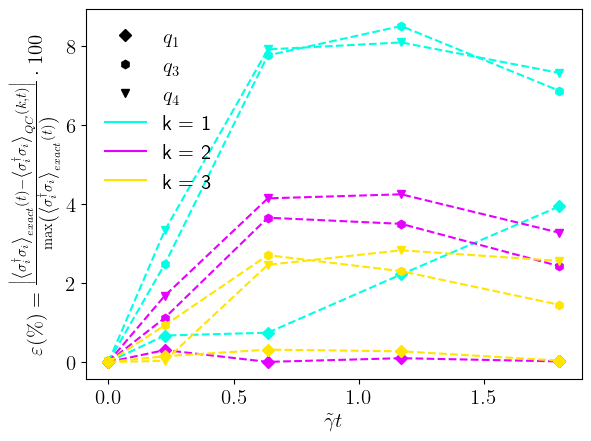

In [10]:
plt.rcParams.update({'font.size': 15})
excited_qubits = initial_state
ground_qubits = [ str(i) for i in range(0, num_emitters) if str(i) not in initial_state]


all_markers = [m for m in markers.MarkerStyle.markers.keys()
               if isinstance(m, str) and len(m) == 1 and m not in [' ', 'None', '']]

selected_markers = random.sample(all_markers, num_emitters)

# Build dictionary
marker_dict = {str(i): selected_markers[i] for i in range(num_emitters)}

colors = generate_complementary_colors(k_max, 'neon', 'turquoise')
for (idx, key) in enumerate(qiskit_evs.keys()):
    for q in excited_qubits:
        error = (np.abs(np.array(qiskit_evs[key][q]) - np.array(exact_evs[q]))/max(exact_evs[q]))*100
        plt.plot(0.009*t, error, linestyle = 'dashed', marker = marker_dict[q], color = colors[idx])

for q in excited_qubits:
    plt.plot(np.nan, np.nan, linestyle = 'none', marker = marker_dict[q], color = 'black', label = f'$q_{int(q)}$')

for (idx,key) in enumerate(qiskit_evs.keys()):
    plt.plot(np.nan, np.nan, linestyle = 'solid', color = colors[idx], label = key)

plt.ylabel(r'$ \varepsilon (\%) = \frac{\left| \left< \sigma^{\dagger}_i \sigma_i \right>_{exact} (t) - \left< \sigma^{\dagger}_i \sigma_i \right>_{QC} (k, t)  \right|}{\max \left( \left< \sigma^{\dagger}_i \sigma_i \right>_{exact} (t) \right)} \cdot 100 $')
plt.xlabel('$\\tilde{\\gamma} t$')
# plt.title(r'$\left\lbrace q_i : \left| \psi (t=0) \right>_{q_i} = \left| 1 \right>_{q_i}  \right\rbrace$')
plt.legend(frameon = False)
plt.savefig('../figs/excited_qubits_trotter_analysis.svg', transparent = True, bbox_inches = 'tight')
plt.show()

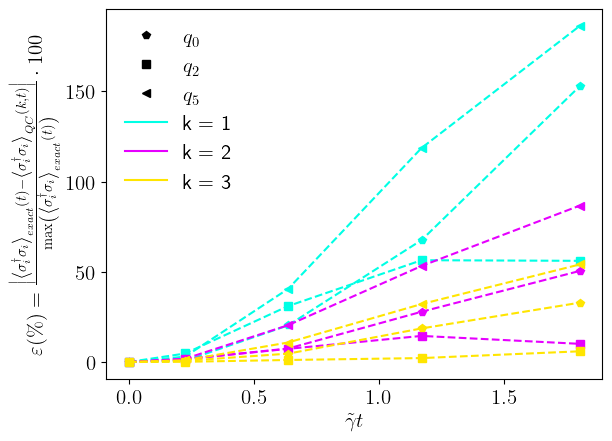

In [11]:
for (idx, key) in enumerate(qiskit_evs.keys()):
    for q in ground_qubits:
        error = (np.abs(np.array(qiskit_evs[key][q]) - np.array(exact_evs[q]))/max(exact_evs[q]))*100
        plt.plot(0.009*t, error, linestyle = 'dashed', marker = marker_dict[q], color = colors[idx])

for q in ground_qubits:
    plt.plot(np.nan, np.nan, linestyle = 'none', marker = marker_dict[q], color = 'black', label = f'$q_{int(q)}$')

for (idx,key) in enumerate(qiskit_evs.keys()):
    plt.plot(np.nan, np.nan, linestyle = 'solid', color = colors[idx], label = key)

plt.ylabel(r'$ \varepsilon (\%) = \frac{\left| \left< \sigma^{\dagger}_i \sigma_i \right>_{exact} (t) - \left< \sigma^{\dagger}_i \sigma_i \right>_{QC} (k, t)  \right|}{\max \left( \left< \sigma^{\dagger}_i \sigma_i \right>_{exact} (t) \right)} \cdot 100 $')
plt.xlabel('$\\tilde{\\gamma} t$')
#plt.title(r'$\left\lbrace q_i : \left| \psi (t=0) \right>_{q_i} = \left| 0 \right>_{q_i}  \right\rbrace$')
plt.legend(frameon = False)
plt.savefig('../figs/ground_qubits_trotter_analysis.svg', transparent = True, bbox_inches = 'tight')
plt.show()

We should do a randomized benchmark for this (i.e., choose random initial states and plot them on the graph separated by ground and excited)

In [3]:
num_emitters = 6
omega_m = [1.2]*num_emitters
omega_c = 1.1
gamma = [0.8*10**(-6)]*num_emitters
kappa = [0.2]
g = [0.03]*(2*(num_emitters-1)) 
t = 200*(np.linspace(0, 1, 5)**1.5)
optimization_level = 2
noisy_backend = service.backend("ibm_kingston")
shots = 4*(0.5*10**4)

Starting with qubits ['1', '5', '4'] initially excited!
[1.2045, 1.2045000000000001, 1.2045000000000001, 1.2045000000000001, 1.2045000000000001, 1.2045] [0.0045, 0.0045, 0.0045, 0.0045, 0.0045] [0.009000800000000012, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.009000800000000012] [0.009000000000000011, 0.009000000000000011, 0.009000000000000011, 0.009000000000000011, 0.009000000000000011] [7.999999999987184e-07, 7.999999999987184e-07, 7.999999999987184e-07, 7.999999999987184e-07, 7.999999999987184e-07] [0.01800080000000002, 0.01800080000000002, 0.01800080000000002, 0.01800080000000002, 0.01800080000000002] [7.999999999987184e-07, 7.999999999987184e-07, 7.999999999987184e-07, 7.999999999987184e-07, 7.999999999987184e-07] [0.01800080000000002, 0.01800080000000002, 0.01800080000000002, 0.01800080000000002, 0.01800080000000002]
k = 1 done!
[1.2045, 1.2045000000000001, 1.2045000000000001, 1.2045000000000001, 1.2045000000000001, 1.2045] [0.0045, 0.00

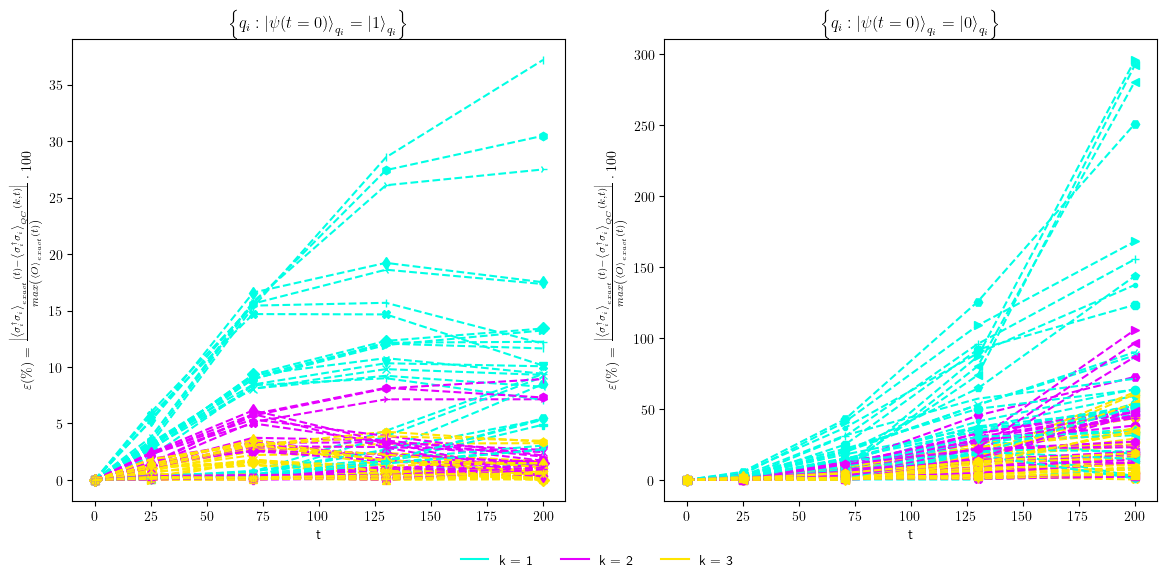

In [ ]:
k_max = 3
colors = generate_complementary_colors(k_max, 'neon', 'turquoise')
sampler = SamplerV2(mode = AerSimulator(), options = {'default_shots' : shots})
pm = generate_preset_pass_manager(optimization_level = 2, backend = noisy_backend)
all_markers = [m for m in markers.MarkerStyle.markers.keys()
               if isinstance(m, str) and len(m) == 1 and m not in [' ', 'None', '']]

samples = 10
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes = axes.flatten()  

ground_error = { f'k = {int(i)}' : [] for i in range(1, k_max + 1, 1) }
excited_error = { f'k = {int(i)}' : [] for i in range(1, k_max + 1, 1) }

abs_ground_error = { f'k = {int(i)}' : [] for i in range(1, k_max + 1, 1) }
abs_excited_error = { f'k = {int(i)}' : [] for i in range(1, k_max + 1, 1) }

total_population_qiskit = { f'k = {int(i)}' : [] for i in range(1, k_max + 1, 1) }
total_population_qutip = { f'k = {int(i)}' : [] for i in range(1, k_max + 1, 1) }
for _ in range(samples):
    list_length = random.randint(2, 4)
    random_integers = random.sample(range(0, num_emitters), list_length)
    initial_state = [str(i) for i in random_integers]
    print(f'Starting with qubits {initial_state} initially excited!')

    qiskit_evs = {}
    for i in range(1, k_max + 1, 1):
        qc  = test_circuit(num_emitters, omega_m, omega_c, g, gamma, kappa, initial_state, i)
        qc.measure_all()
        isa_qc = pm.run(qc)
        pubs = [(isa_qc, x) for x in t]
        job = sampler.run(pubs)
        result = job.result()
        evs, std = get_populations(num_emitters, result)
        qiskit_evs[f'k = {int(i)}'] = evs

        total_pop = np.zeros(len(t))
        for q in evs.keys():
            total_pop = total_pop + evs[q]

        total_population_qiskit[f'k = {int(i)}'].append(total_pop)
        print(f'k = {i} done!')

    exact_evs = solve_diag_ME(num_emitters, omega_m, omega_c, gamma, kappa, g, t, initial_state)
    total_pop = np.zeros(len(t))
    for q in exact_evs.keys():
        total_pop = total_pop + exact_evs[q]
    
    total_population_qutip.append(total_pop)

    excited_qubits = initial_state
    ground_qubits = [ str(i) for i in range(0, num_emitters) if str(i) not in initial_state]

    selected_markers = random.sample(all_markers, num_emitters)
    marker_dict = {str(i): selected_markers[i] for i in range(num_emitters)}

    ax = axes[0]
    for (idx, key) in enumerate(qiskit_evs.keys()):
        for q in excited_qubits:
            abs_error = np.abs(np.array(qiskit_evs[key][q]) - np.array(exact_evs[q]))
            abs_excited_error[key].append(abs_error)

            error = (abs_error/max(exact_evs[q]))*100
            ax.plot(t, error, linestyle = 'dashed', marker = marker_dict[q], color = colors[idx])
            excited_error[key].append(error)

    ax = axes[1]
    for (idx, key) in enumerate(qiskit_evs.keys()):
        for q in ground_qubits:
            abs_error = np.abs(np.array(qiskit_evs[key][q]) - np.array(exact_evs[q]))
            abs_ground_error[key].append(abs_error)

            error = (abs_error/max(exact_evs[q]))*100
            ax.plot(t, error, linestyle = 'dashed', marker = marker_dict[q], color = colors[idx])
            ground_error[key].append(error)

axes[1].set_ylabel(r'$ \varepsilon (\%) = \frac{\left| \left< \sigma^{\dagger}_i \sigma_i \right>_{exact} (t) - \left< \sigma^{\dagger}_i \sigma_i \right>_{QC} (k, t)  \right|}{max \left( \left<O \right>_{exact} (t) \right)} \cdot 100 $')
axes[1].set_xlabel('t')
axes[1].set_title(r'$\left\lbrace q_i : \left| \psi (t=0) \right>_{q_i} = \left| 0 \right>_{q_i}  \right\rbrace$')

axes[0].set_ylabel(r'$ \varepsilon (\%) = \frac{\left| \left< \sigma^{\dagger}_i \sigma_i \right>_{exact} (t) - \left< \sigma^{\dagger}_i \sigma_i \right>_{QC} (k, t)  \right|}{max \left( \left<O \right>_{exact} (t) \right)} \cdot 100 $')
axes[0].set_xlabel('t')
axes[0].set_title(r'$\left\lbrace q_i : \left| \psi (t=0) \right>_{q_i} = \left| 1 \right>_{q_i}  \right\rbrace$')

handles = [
    plt.Line2D([], [], linestyle='solid', color=colors[0], label='k = 1'),
    plt.Line2D([], [], linestyle='solid', color=colors[1], label='k = 2'),
    plt.Line2D([], [], linestyle='solid', color=colors[2], label='k = 3')
]

fig.legend(handles=handles, loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.02))

np.savez('ground_error', ground_error, abs_ground_error)
np.savez('excited_error', excited_error, abs_excited_error)
np.savez('total_populations', total_population_qiskit, total_population_qutip)

plt.savefig('randomized_trotter_analysis', bbox_inches = 'tight')
plt.show()   

In [ ]:
total_population_qutip = []
initial_states = [ ['1', '5', '4'], ['0', '3'], ['3', '2', '0'], ['2', '3', '1'], ['1', '5'], ['5', '2'], ['0', '3', '5', '2'], ['5', '4', '1', '3'], ['3', '2', '0', '1'],  ['2', '5'] ]
for state in initial_states:
    exact_evs = solve_diag_ME(num_emitters, omega_m, omega_c, gamma, kappa, g, t, state)
    total_pop = np.zeros(len(t))
    for q in exact_evs.keys():
        total_pop = total_pop + exact_evs[q]
    
    total_population_qutip.append(total_pop)

[0.009000800000000012, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.009000800000000012]
[0.009000800000000012, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.009000800000000012]
[0.009000800000000012, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.009000800000000012]
[0.009000800000000012, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.009000800000000012]
[0.009000800000000012, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.009000800000000012]
[0.009000800000000012, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.009000800000000012]
[0.009000800000000012, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.009000800000000012]
[0.009000800000000012, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.009000800

In [2]:
a = np.load('total_populations.npz', allow_pickle = True) 
qiskit_pop = a['arr_0'].item() # relatve error ground qubits
qutip_pops = a['arr_1'] # absolute error 

In [3]:
qutip_pops

array([[3.        , 2.0945176 , 1.20183818, 0.72826476, 0.51149808],
       [2.        , 1.48700383, 1.01717603, 0.73397243, 0.55428154],
       [3.        , 2.09620692, 1.20928158, 0.7256166 , 0.48868541],
       [3.        , 1.90084358, 0.8917373 , 0.46859315, 0.32997317],
       [2.        , 1.48890635, 1.03915593, 0.7940594 , 0.63905119],
       [2.        , 1.48700383, 1.01717603, 0.73397243, 0.55428154],
       [4.        , 2.91052204, 1.79773077, 1.12593691, 0.75188312],
       [4.        , 2.71017024, 1.44862299, 0.82660147, 0.56535258],
       [4.        , 2.65716891, 1.29201046, 0.63082989, 0.37624188],
       [2.        , 1.48700383, 1.01717603, 0.73397243, 0.55428154]])

In [4]:
qiskit_pop

{'k = 1': [array([3.     , 2.1639 , 1.50475, 1.25835, 1.13685]),
  array([2.     , 1.48375, 1.00945, 0.7868 , 0.707  ]),
  array([3.     , 2.1648 , 1.43625, 1.104  , 0.9979 ]),
  array([3.     , 2.0169 , 1.26575, 1.00405, 1.0002 ]),
  array([2.     , 1.4928 , 1.0509 , 0.8368 , 0.70965]),
  array([2.    , 1.4827, 1.0131, 0.7848, 0.7083]),
  array([4.     , 2.96825, 2.02835, 1.5329 , 1.33355]),
  array([4.     , 2.8459 , 1.9108 , 1.54155, 1.4126 ]),
  array([4.     , 2.8221 , 1.86695, 1.4677 , 1.35255]),
  array([2.     , 1.48945, 1.0151 , 0.7858 , 0.70585])],
 'k = 2': [array([3.    , 2.1284, 1.3128, 0.885 , 0.6877]),
  array([2.     , 1.48735, 1.00855, 0.71935, 0.5768 ]),
  array([3.     , 2.1179 , 1.2731 , 0.78855, 0.5716 ]),
  array([3.     , 1.9571 , 1.02165, 0.6223 , 0.5099 ]),
  array([2.     , 1.4816 , 1.0352 , 0.7997 , 0.66095]),
  array([2.     , 1.48655, 1.0066 , 0.72875, 0.57905]),
  array([4.     , 2.9354 , 1.8505 , 1.1673 , 0.78015]),
  array([4.     , 2.7597 , 1.62375, 1.0

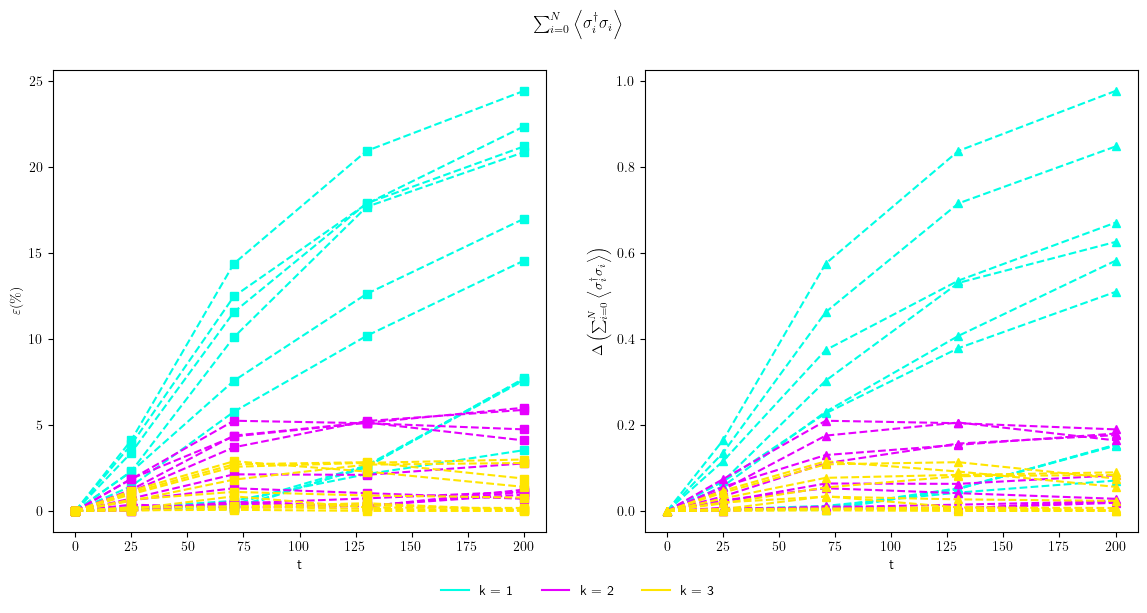

In [51]:
a = np.load('total_populations.npz', allow_pickle = True) 
qiskit_pop = a['arr_0'].item() # relatve error ground qubits
qutip_pops = a['arr_1'] # absolute error 

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for (idx, (key, value)) in enumerate(qiskit_pop.items()):
    for (qiskit_curve, qutip_curve) in zip(value, qutip_pops):
        normalization = max(qutip_curve)
        abs_error = np.abs(qiskit_curve - qutip_curve)
        rel_error = (abs_error/normalization)*100

        axes[0].plot(t, rel_error, color = colors[idx], linestyle = 'dashed', marker = 's')
        axes[1].plot(t, abs_error, color = colors[idx], linestyle = 'dashed', marker = '^')

axes[0].set_ylabel(r'$ \varepsilon (\%) $')
axes[0].set_xlabel('t')

axes[1].set_ylabel(r'$ \Delta \left( \sum_{i=0}^N \left< \sigma^{\dagger}_i \sigma_i \right> \right)$')
axes[1].set_xlabel('t')

handles = [
    plt.Line2D([], [], linestyle='solid', color=colors[0], label='k = 1'),
    plt.Line2D([], [], linestyle='solid', color=colors[1], label='k = 2'),
    plt.Line2D([], [], linestyle='solid', color=colors[2], label='k = 3')
]

fig.legend(handles=handles, loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.02))
fig.suptitle(r'$\sum_{i=0}^N \left< \sigma^{\dagger}_i \sigma_i \right>$', y=0.98)
plt.savefig('6_qubits_random_sampling_total_population', bbox_inches = 'tight')
plt.show()   


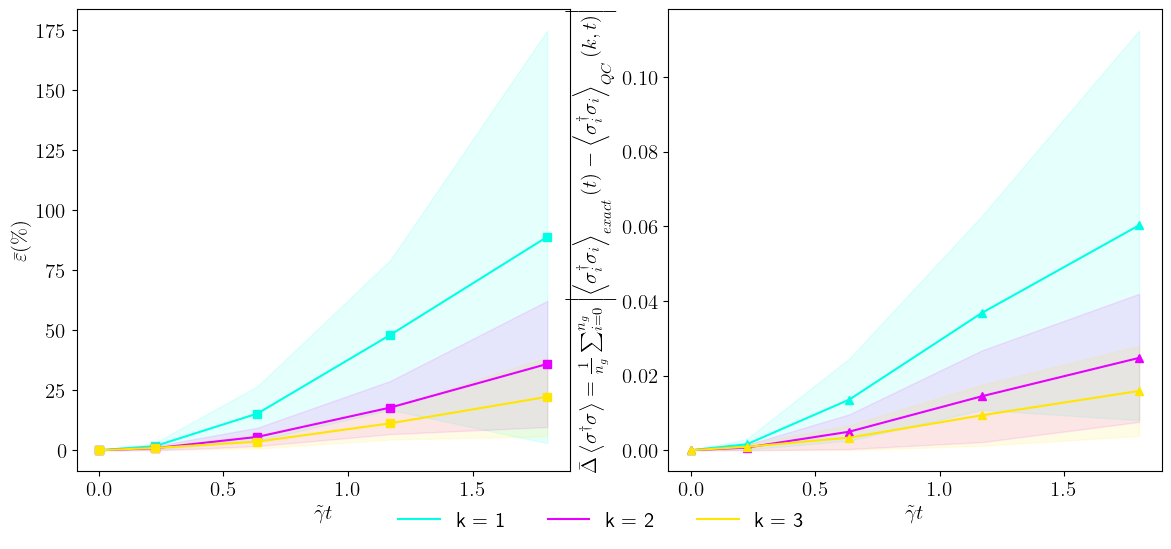

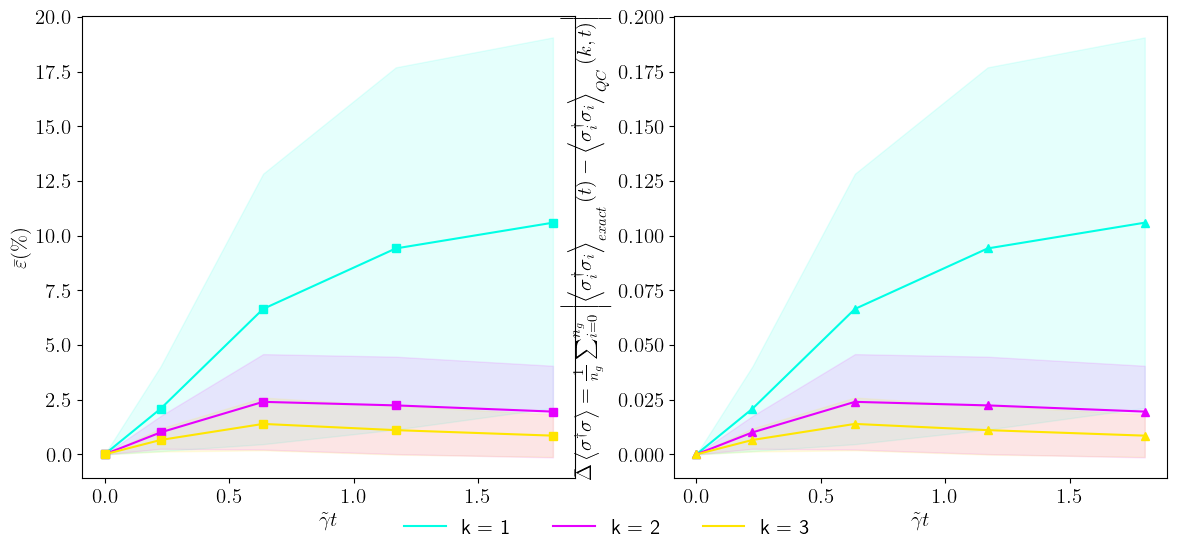

In [15]:
k_max = 3
colors = generate_complementary_colors(k_max, 'neon', 'turquoise')

a = np.load('../datasets/ground_error_6_emitters.npz', allow_pickle = True) 
re_gq = a['arr_0'].item() # relatve error ground qubits
ae_gq = a['arr_1'].item() # absolute error 

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax = axes[0]
for (idx, (key, value)) in enumerate(re_gq.items()):
    average_error = np.mean(value, axis = 0)
    std = np.std(value, axis = 0)

    ax.plot(0.009*t, average_error, color = colors[idx], linestyle = 'solid', marker = 's')
    upper_bound = average_error + std
    lower_bound = average_error - std
    ax.fill_between(0.009*t, lower_bound, upper_bound, color=colors[idx], alpha=0.1)
    
axes[0].set_ylabel(r'$ \bar{\varepsilon} (\%) $')
axes[0].set_xlabel('$\\tilde{\\gamma} t$')

ax = axes[1]
for (idx, (key, value)) in enumerate(ae_gq.items()):
    average_error = np.mean(value, axis = 0)
    std = np.std(value, axis = 0)

    ax.plot(0.009*t, average_error, color = colors[idx], linestyle = 'solid', marker = '^')
    upper_bound = average_error + std
    lower_bound = average_error - std
    ax.fill_between(0.009*t, lower_bound, upper_bound, color=colors[idx], alpha=0.1)
    
axes[1].set_ylabel(r'$ \bar{\Delta} \left< \sigma^{\dagger} \sigma \right> = \frac{1}{n_g} \sum_{i=0}^{n_g} \left| \left< \sigma^{\dagger}_i \sigma_i \right>_{exact} (t) - \left< \sigma^{\dagger}_i \sigma_i \right>_{QC} (k, t)  \right| $')
axes[1].set_xlabel('$\\tilde{\\gamma} t$')


handles = [
    plt.Line2D([], [], linestyle='solid', color=colors[0], label='k = 1'),
    plt.Line2D([], [], linestyle='solid', color=colors[1], label='k = 2'),
    plt.Line2D([], [], linestyle='solid', color=colors[2], label='k = 3')
]

fig.legend(handles=handles, loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.02))
plt.savefig('../figs/6_qubits_averaged_trotter_error_ground_qubits.svg', bbox_inches = 'tight', transparent = True)
plt.show()   

a = np.load('../datasets/excited_error_6_emitters.npz', allow_pickle = True) 
re_eq = a['arr_0'].item() # relatve error excited qubits
ae_eq = a['arr_1'].item() # absolute error 

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax = axes[0]
for (idx, (key, value)) in enumerate(re_eq.items()):
    average_error = np.mean(value, axis = 0)
    std = np.std(value, axis = 0)

    ax.plot(0.009*t, average_error, color = colors[idx], linestyle = 'solid', marker = 's')
    upper_bound = average_error + std
    lower_bound = average_error - std
    ax.fill_between(0.009*t, lower_bound, upper_bound, color=colors[idx], alpha=0.1)
    
axes[0].set_ylabel(r'$ \bar{\varepsilon} (\%) $')
axes[0].set_xlabel('$\\tilde{\\gamma} t$')

ax = axes[1]
for (idx, (key, value)) in enumerate(ae_eq.items()):
    average_error = np.mean(value, axis = 0)
    std = np.std(value, axis = 0)

    ax.plot(0.009*t, average_error, color = colors[idx], linestyle = 'solid', marker = '^')
    upper_bound = average_error + std
    lower_bound = average_error - std
    ax.fill_between(0.009*t, lower_bound, upper_bound, color=colors[idx], alpha=0.1)
    
axes[1].set_ylabel(r'$ \bar{\Delta} \left< \sigma^{\dagger} \sigma \right> = \frac{1}{n_g} \sum_{i=0}^{n_g} \left| \left< \sigma^{\dagger}_i \sigma_i \right>_{exact} (t) - \left< \sigma^{\dagger}_i \sigma_i \right>_{QC} (k, t)  \right| $')
axes[1].set_xlabel('$\\tilde{\\gamma} t$')

handles = [
    plt.Line2D([], [], linestyle='solid', color=colors[0], label='k = 1'),
    plt.Line2D([], [], linestyle='solid', color=colors[1], label='k = 2'),
    plt.Line2D([], [], linestyle='solid', color=colors[2], label='k = 3')
]

fig.legend(handles=handles, loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.02))
#fig.suptitle(r'$\left\lbrace q_i : \left| \psi (t=0) \right>_{q_i} = \left| 1 \right>_{q_i}  \right\rbrace$', y=0.98)
plt.savefig('../figs/6_qubits_averaged_trotter_error_excited_qubits.svg', bbox_inches = 'tight', transparent = True)
plt.show()   

Now we will repeat this procedure for different system sizes (3, 4, 5, 6, 7, 8 emitters) and plot the average errors obtained for different Trotter steps in different graphs (i.e., one for k=1, another for k=2 and another for k=3). We do this to see whether or not we can predict the curves for larger $n$.

In [26]:
#n = [3, 4, 5]
n = [7, 8]
t = 200*(np.linspace(0, 1, 5)**1.5)
optimization_level = 2
noisy_backend = service.backend("ibm_kingston")
shots = 4*(0.5*10**4)
k_max = 3

sampler = SamplerV2(mode = AerSimulator(), options = {'default_shots' : shots})
pm = generate_preset_pass_manager(optimization_level = 2, backend = noisy_backend)
samples = 10

for num_emitters in n:
    print(f'Retrieving data for {num_emitters} emitters!')
    omega_m = [1.2]*num_emitters
    omega_c = 1.1
    gamma = [0.8*10**(-6)]*num_emitters
    kappa = [0.2]
    g = [0.03]*(2*(num_emitters-1)) 


    ground_error = { f'k = {int(i)}' : [] for i in range(1, k_max + 1, 1) }
    excited_error = { f'k = {int(i)}' : [] for i in range(1, k_max + 1, 1) }

    abs_ground_error = { f'k = {int(i)}' : [] for i in range(1, k_max + 1, 1) }
    abs_excited_error = { f'k = {int(i)}' : [] for i in range(1, k_max + 1, 1) }

    total_population_qiskit = { f'k = {int(i)}' : [] for i in range(1, k_max + 1, 1) }
    total_population_qutip = []
    for _ in range(samples):
        a = num_emitters - 3
        if num_emitters == 3:
            a = 1
        b = num_emitters - 1
        list_length = random.randint(a, b)
        random_integers = random.sample(range(0, num_emitters), list_length)
        initial_state = [str(i) for i in random_integers]
        print(f'Starting with qubits {initial_state} initially excited!')

        qiskit_evs = {}
        for i in range(1, k_max + 1, 1):
            qc  = test_circuit(num_emitters, omega_m, omega_c, g, gamma, kappa, initial_state, i)
            qc.measure_all()
            isa_qc = pm.run(qc)
            pubs = [(isa_qc, x) for x in t]
            job = sampler.run(pubs)
            result = job.result()
            evs, std = get_populations(num_emitters, result)
            qiskit_evs[f'k = {int(i)}'] = evs

            total_pop = np.zeros(len(t))
            for q in evs.keys():
                total_pop = total_pop + evs[q]

            total_population_qiskit[f'k = {int(i)}'].append(total_pop)
            print(f'k = {i} done!')

        exact_evs = solve_diag_ME(num_emitters, omega_m, omega_c, gamma, kappa, g, t, initial_state)
        total_pop = np.zeros(len(t))
        for q in exact_evs.keys():
            total_pop = total_pop + exact_evs[q]
        
        total_population_qutip.append(total_pop)

        excited_qubits = initial_state
        ground_qubits = [ str(i) for i in range(0, num_emitters) if str(i) not in initial_state]

        for (idx, key) in enumerate(qiskit_evs.keys()):
            for q in excited_qubits:
                abs_error = np.abs(np.array(qiskit_evs[key][q]) - np.array(exact_evs[q]))
                abs_excited_error[key].append(abs_error)

                error = (abs_error/max(exact_evs[q]))*100
                excited_error[key].append(error)

        for (idx, key) in enumerate(qiskit_evs.keys()):
            for q in ground_qubits:
                abs_error = np.abs(np.array(qiskit_evs[key][q]) - np.array(exact_evs[q]))
                abs_ground_error[key].append(abs_error)

                error = (abs_error/max(exact_evs[q]))*100
                ground_error[key].append(error)
                
    np.savez(f'ground_error_{num_emitters}_emitters', ground_error, abs_ground_error)
    np.savez(f'excited_error_{num_emitters}_emitters', excited_error, abs_excited_error)
    np.savez(f'total_populations_{num_emitters}_emitters', total_population_qiskit, total_population_qutip)

Retrieving data for 7 emitters!
Starting with qubits ['4', '0', '3', '5', '6', '1'] initially excited!
[1.2045, 1.2045000000000001, 1.2045000000000001, 1.2045000000000001, 1.2045000000000001, 1.2045000000000001, 1.2045] [0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045] [0.009000800000000012, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.009000800000000012] [0.009000000000000011, 0.009000000000000011, 0.009000000000000011, 0.009000000000000011, 0.009000000000000011, 0.009000000000000011] [7.999999999987184e-07, 7.999999999987184e-07, 7.999999999987184e-07, 7.999999999987184e-07, 7.999999999987184e-07, 7.999999999987184e-07] [0.01800080000000002, 0.01800080000000002, 0.01800080000000002, 0.01800080000000002, 0.01800080000000002, 0.01800080000000002] [7.999999999987184e-07, 7.999999999987184e-07, 7.999999999987184e-07, 7.999999999987184e-07, 7.999999999987184e-07, 7.999999999987184e-07] [0.01800080000000002, 0.01800080000000002, 

MemoryError: Unable to allocate 4.00 GiB for an array with shape (128, 128, 128, 128) and data type complex128

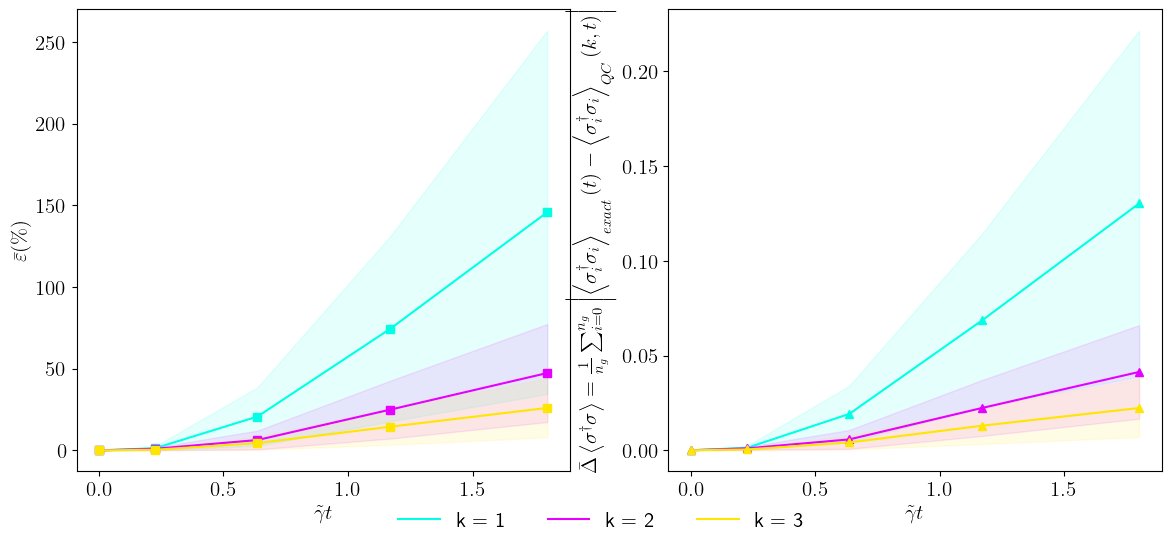

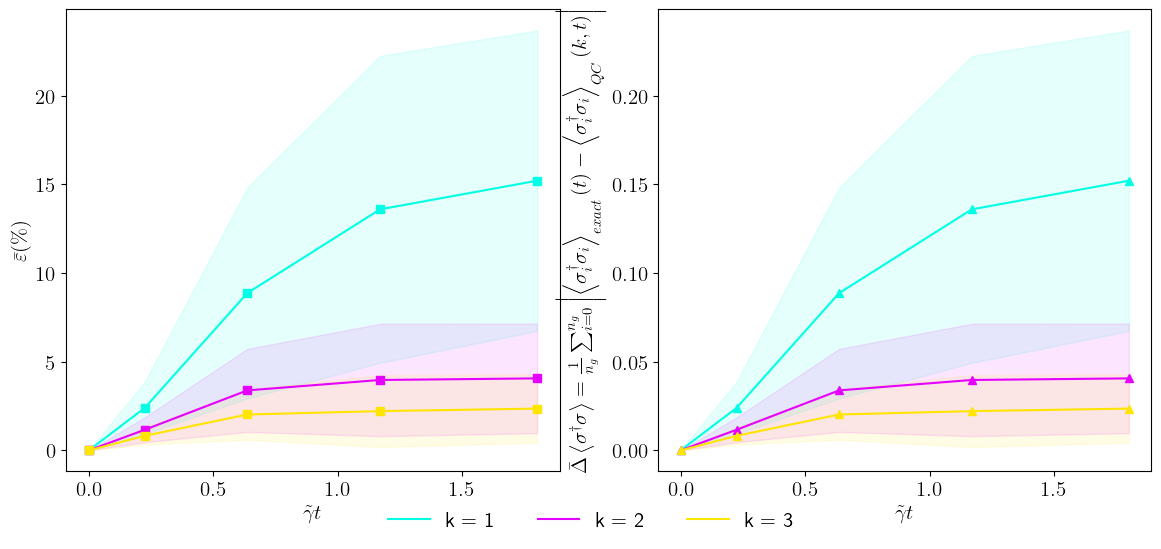

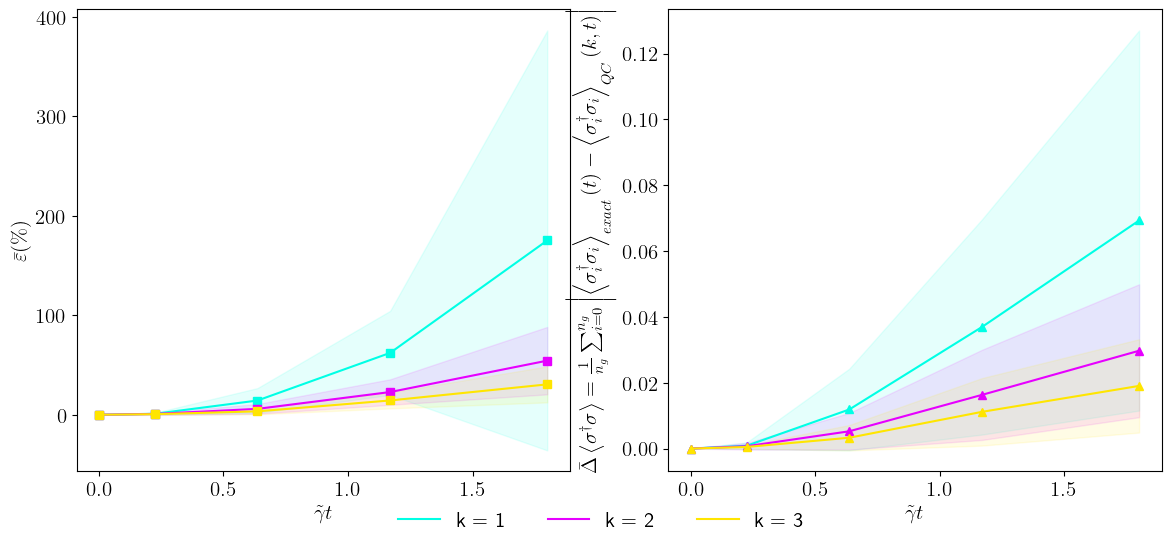

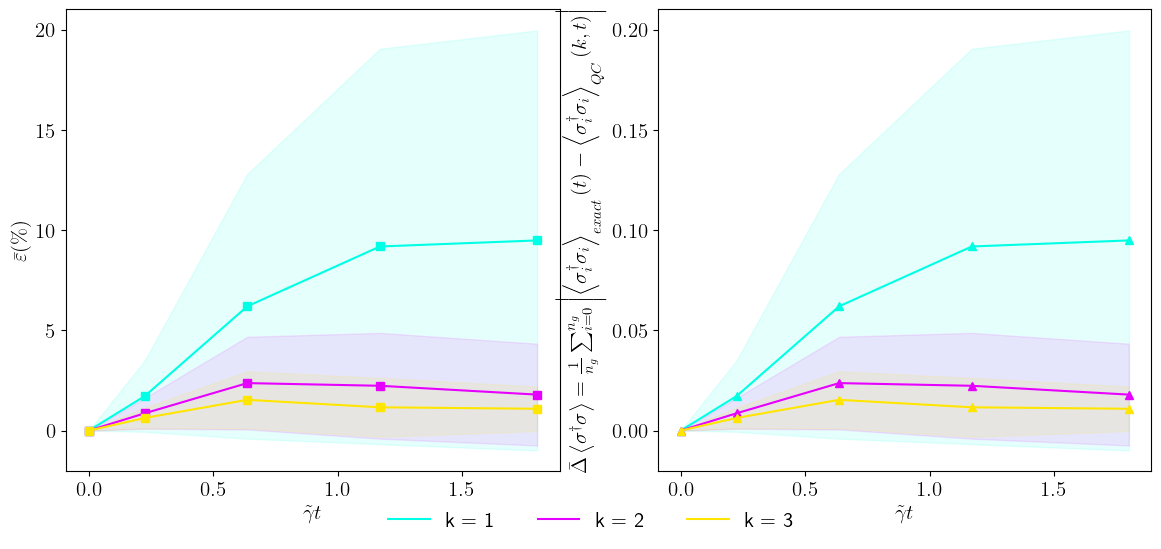

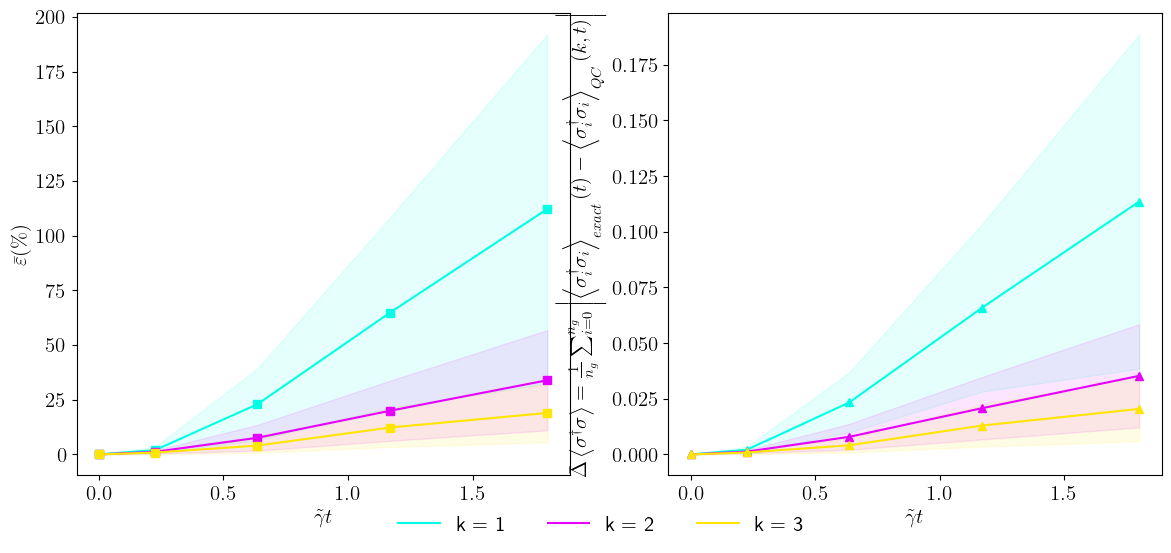

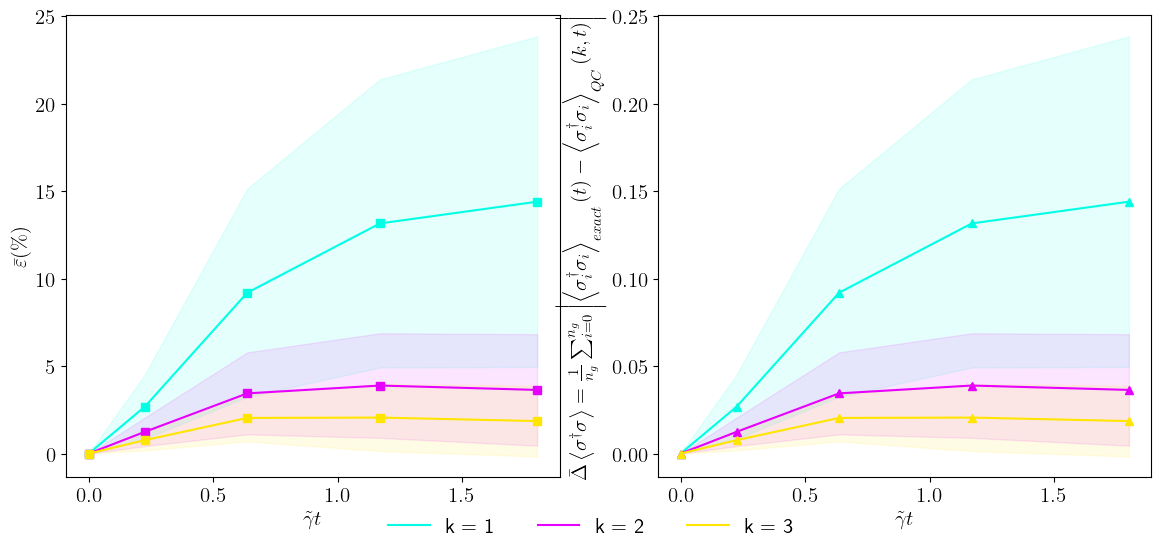

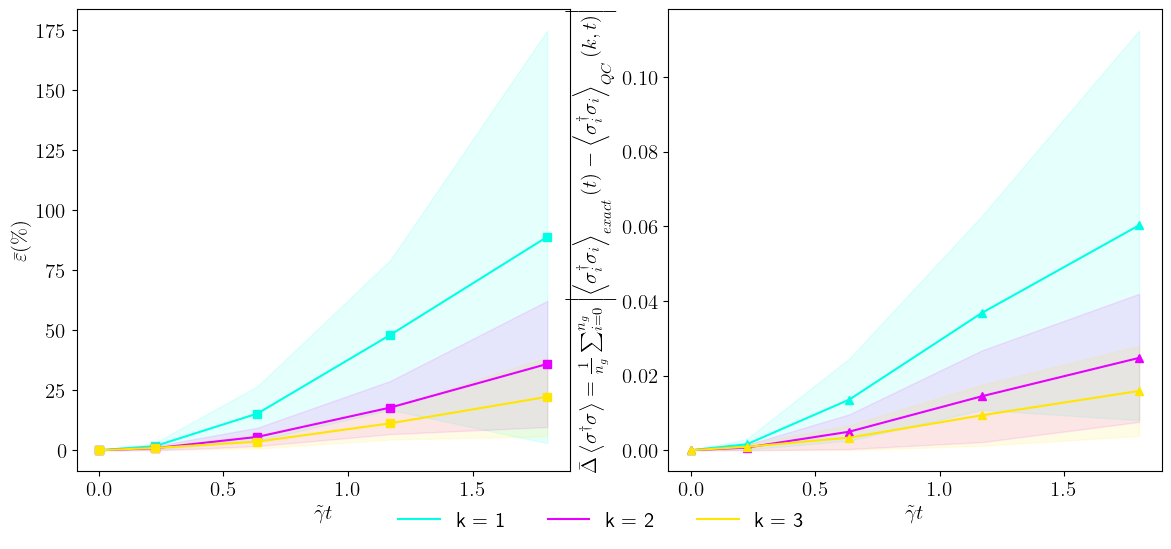

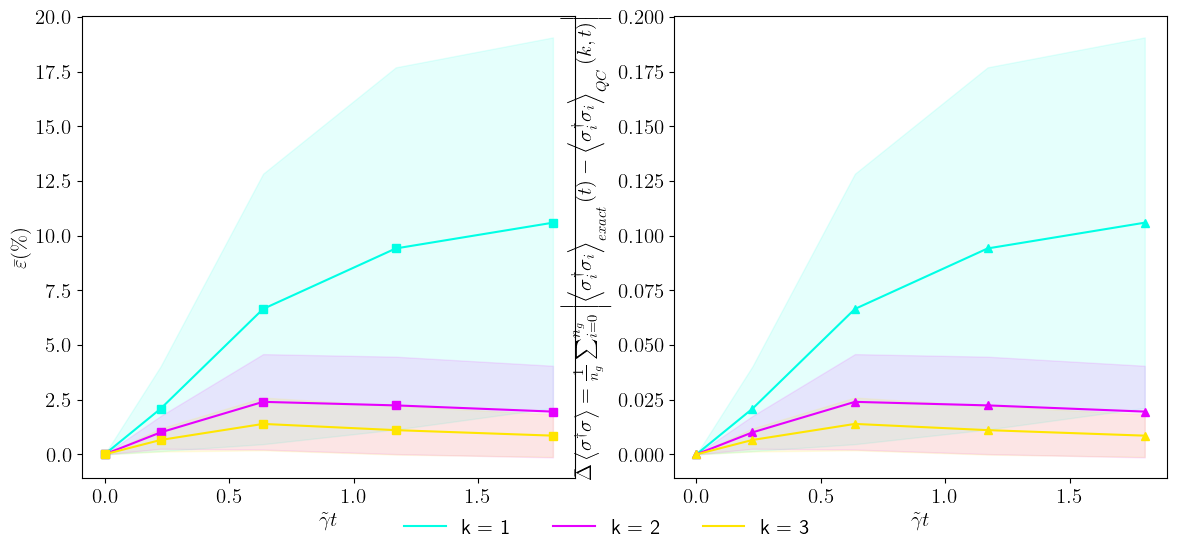

In [17]:
n = [3, 4, 5, 6]
k_max = 3
colors = generate_complementary_colors(k_max, 'neon', 'turquoise')

ground_averages_rel_error = { f'k = {i}' : [] for i in range(1, k_max +1, 1) }
ground_stds_rel_error = { f'k = {i}' : [] for i in range(1, k_max +1, 1) }
ground_averages_abs_error = { f'k = {i}' : [] for i in range(1, k_max +1, 1) }
ground_stds_abs_error = { f'k = {i}' : [] for i in range(1, k_max +1, 1) }

excited_averages_rel_error = { f'k = {i}' : [] for i in range(1, k_max +1, 1) }
excited_stds_rel_error = { f'k = {i}' : [] for i in range(1, k_max +1, 1) }
excited_averages_abs_error = { f'k = {i}' : [] for i in range(1, k_max +1, 1) }
excited_stds_abs_error = { f'k = {i}' : [] for i in range(1, k_max +1, 1) }
for num_emitters in n:

    a = np.load(f'../datasets/ground_error_{num_emitters}_emitters.npz', allow_pickle = True) 
    re_gq = a['arr_0'].item() # relatve error ground qubits
    ae_gq = a['arr_1'].item() # absolute error 

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    ax = axes[0]
    for (idx, (key, value)) in enumerate(re_gq.items()):
        average_error = np.mean(value, axis = 0)
        std = np.std(value, axis = 0)

        ground_averages_rel_error[key].append(average_error)
        ground_stds_rel_error[key].append(std)

        ax.plot(0.009*t, average_error, color = colors[idx], linestyle = 'solid', marker = 's')
        upper_bound = average_error + std
        lower_bound = average_error - std
        ax.fill_between(0.009*t, lower_bound, upper_bound, color=colors[idx], alpha=0.1)
        
    axes[0].set_ylabel(r'$ \bar{\varepsilon} (\%) $')
    axes[0].set_xlabel('$\\tilde{\\gamma} t$')

    ax = axes[1]
    for (idx, (key, value)) in enumerate(ae_gq.items()):
        average_error = np.mean(value, axis = 0)
        std = np.std(value, axis = 0)

        ground_averages_abs_error[key].append(average_error)
        ground_stds_abs_error[key].append(std)

        ax.plot(0.009*t, average_error, color = colors[idx], linestyle = 'solid', marker = '^')
        upper_bound = average_error + std
        lower_bound = average_error - std
        ax.fill_between(0.009*t, lower_bound, upper_bound, color=colors[idx], alpha=0.1)
        
    axes[1].set_ylabel(r'$ \bar{\Delta} \left< \sigma^{\dagger} \sigma \right> = \frac{1}{n_g} \sum_{i=0}^{n_g} \left| \left< \sigma^{\dagger}_i \sigma_i \right>_{exact} (t) - \left< \sigma^{\dagger}_i \sigma_i \right>_{QC} (k, t)  \right| $')
    axes[1].set_xlabel('$\\tilde{\\gamma} t$')

    handles = [
        plt.Line2D([], [], linestyle='solid', color=colors[0], label='k = 1'),
        plt.Line2D([], [], linestyle='solid', color=colors[1], label='k = 2'),
        plt.Line2D([], [], linestyle='solid', color=colors[2], label='k = 3')
    ]

    fig.legend(handles=handles, loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.02))
    # fig.suptitle(r'$\left\lbrace q_i : \left| \psi (t=0) \right>_{q_i} = \left| 0 \right>_{q_i}  \right\rbrace$', y=0.98)
    plt.savefig(f'../figs/{num_emitters}_qubits_averaged_trotter_error_ground_qubits.svg', bbox_inches = 'tight', transparent = True)
    plt.show()   

    a = np.load(f'../datasets/excited_error_{num_emitters}_emitters.npz', allow_pickle = True) 
    re_eq = a['arr_0'].item() # relatve error excited qubits
    ae_eq = a['arr_1'].item() # absolute error 

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    ax = axes[0]
    for (idx, (key, value)) in enumerate(re_eq.items()):
        average_error = np.mean(value, axis = 0)
        std = np.std(value, axis = 0)

        excited_averages_rel_error[key].append(average_error)
        excited_stds_rel_error[key].append(std)

        ax.plot(0.009*t, average_error, color = colors[idx], linestyle = 'solid', marker = 's')
        upper_bound = average_error + std
        lower_bound = average_error - std
        ax.fill_between(0.009*t, lower_bound, upper_bound, color=colors[idx], alpha=0.1)
        
    axes[0].set_ylabel(r'$ \bar{\varepsilon} (\%) $')
    axes[0].set_xlabel('$\\tilde{\\gamma} t$')

    ax = axes[1]
    for (idx, (key, value)) in enumerate(ae_eq.items()):
        average_error = np.mean(value, axis = 0)
        std = np.std(value, axis = 0)

        excited_averages_abs_error[key].append(average_error)
        excited_stds_abs_error[key].append(std)

        ax.plot(0.009*t, average_error, color = colors[idx], linestyle = 'solid', marker = '^')
        upper_bound = average_error + std
        lower_bound = average_error - std
        ax.fill_between(0.009*t, lower_bound, upper_bound, color=colors[idx], alpha=0.1)
        
    axes[1].set_ylabel(r'$ \bar{\Delta} \left< \sigma^{\dagger} \sigma \right> = \frac{1}{n_g} \sum_{i=0}^{n_g} \left| \left< \sigma^{\dagger}_i \sigma_i \right>_{exact} (t) - \left< \sigma^{\dagger}_i \sigma_i \right>_{QC} (k, t)  \right| $')
    axes[1].set_xlabel('$\\tilde{\\gamma} t$')

    handles = [
        plt.Line2D([], [], linestyle='solid', color=colors[0], label='k = 1'),
        plt.Line2D([], [], linestyle='solid', color=colors[1], label='k = 2'),
        plt.Line2D([], [], linestyle='solid', color=colors[2], label='k = 3')
    ]

    fig.legend(handles=handles, loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.02))
    # fig.suptitle(r'$\left\lbrace q_i : \left| \psi (t=0) \right>_{q_i} = \left| 1 \right>_{q_i}  \right\rbrace$', y=0.98)
    plt.savefig(f'../figs/{num_emitters}_qubits_averaged_trotter_error_excited_qubits.svg', bbox_inches = 'tight', transparent = True)
    plt.show()   

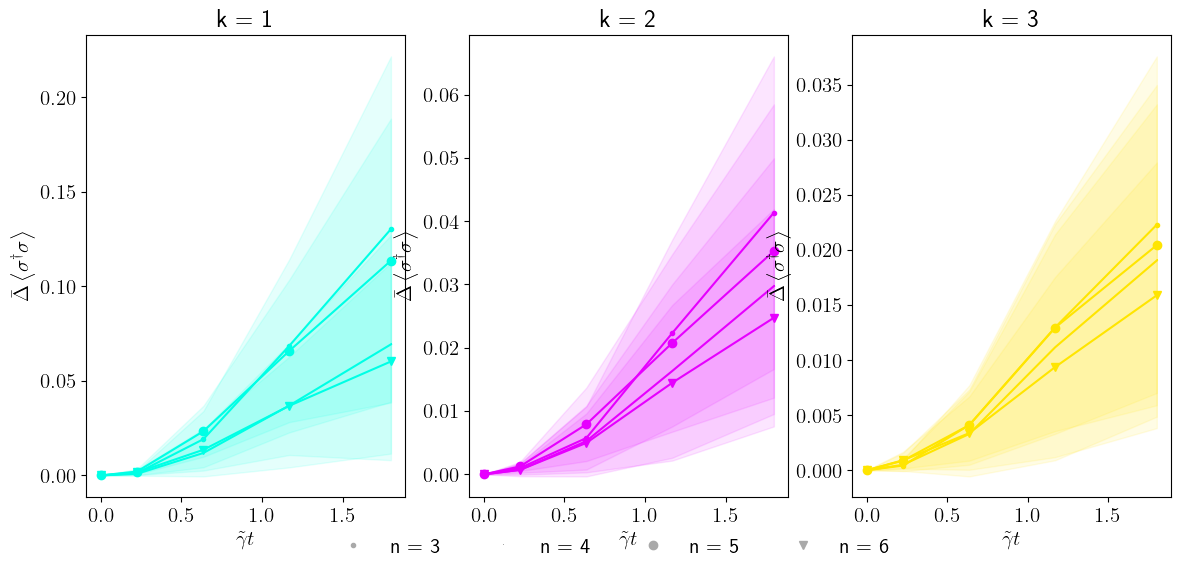

In [20]:
n = [3, 4, 5, 6]
k_max = 3
colors = generate_complementary_colors(k_max, 'neon', 'turquoise')
all_markers = [m for m in markers.MarkerStyle.markers.keys()
               if isinstance(m, str) and len(m) == 1 and m not in [' ', 'None', '']]
all_markers = all_markers[:len(n)]

fig, axes = plt.subplots(1, 3, figsize=(14, 6))

for (idx, (key, value)) in enumerate(ground_averages_abs_error.items()):
    ax = axes[idx]
    for (sub_idx, curve) in enumerate(value):
        ax.plot(0.009*t, curve, color = colors[idx], linestyle = 'solid', marker = all_markers[sub_idx])
        upper_bound = curve + ground_stds_abs_error[key][sub_idx]
        lower_bound = curve - ground_stds_abs_error[key][sub_idx]
        ax.fill_between(0.009*t, lower_bound, upper_bound, color=colors[idx], alpha=0.1)
    
    ax.set_ylabel(r'$ \bar{\Delta} \left< \sigma^{\dagger} \sigma \right> $')
    ax.set_xlabel('$\\tilde{\\gamma} t$')
    ax.set_title(key)

handles = []
for (idx, marker) in enumerate(all_markers):
    handles.append(plt.Line2D([], [], linestyle='none', color='darkgrey', marker=marker, label = f'n = {n[idx]}'))

fig.legend(handles=handles, loc='lower center', ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.02))
plt.savefig(f'../figs/trotter_error_scaling_ground_qubits.svg', bbox_inches = 'tight', transparent = True)
plt.show()   